In [1]:
from fastai.vision.all import *
path = Path('/kaggle/input/image-classification-real-or-ai-generated-photo')

In [2]:
trn_path = Path('images_small')
resize_images(path/'train/train', dest=trn_path, max_size=256, recurse=True)

#### Setup the method for getting the images type i.e. ai flower or flower

In [3]:
df = pd.read_csv(path/'train.csv', index_col='Image')
df.head()

,Label
Image,
1.jpg,0
2.jpg,0
3.jpg,1
4.jpg,1
5.jpg,0


In [4]:
def get_type(p): return df.loc[p.name, 'Label']
get_type(df.iloc[0])

0

#### Resize to square dimensions, adding padding where needed. 

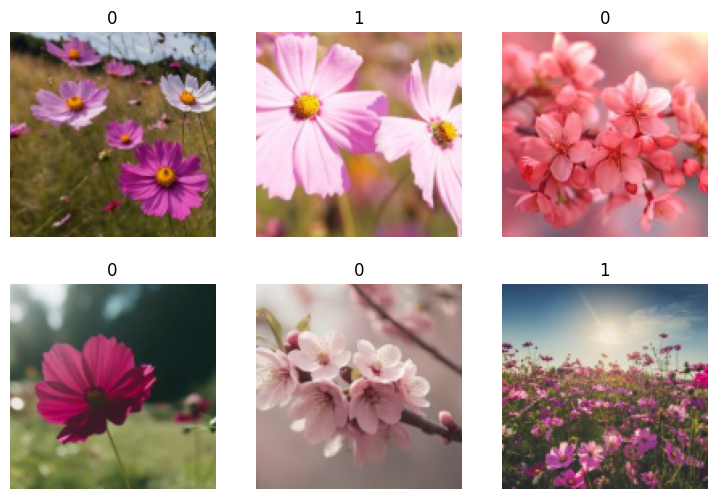

In [5]:
dls = DataBlock(
    blocks = (ImageBlock, CategoryBlock),
    get_items = get_image_files,
    splitter = RandomSplitter(valid_pct=0.2, seed = 42),
    get_y = get_type,
    item_tfms = [Resize((256, 256), method=ResizeMethod.Pad, pad_mode="zeros")],
    batch_tfms = aug_transforms(size=128, min_scale=0.75)
).dataloaders(trn_path, bs=64)

dls.show_batch(max_n=6)

### Since we are dealing with a small dataset of around 1k images, using a small architecture with a very high weight decay gives us the best results

In [29]:
learn = vision_learner(dls, "convnext_small_in22k", metrics=error_rate, wd=0.01).to_fp16()

/opt/conda/lib/python3.10/site-packages/fastai/callback/fp16.py:45: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()
/opt/conda/lib/python3.10/site-packages/fastai/callback/fp16.py:45: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()


/opt/conda/lib/python3.10/site-packages/fastai/learner.py:51: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kwargs

SuggestedLRs(valley=0.0008317637839354575, slide=0.0020892962347716093)

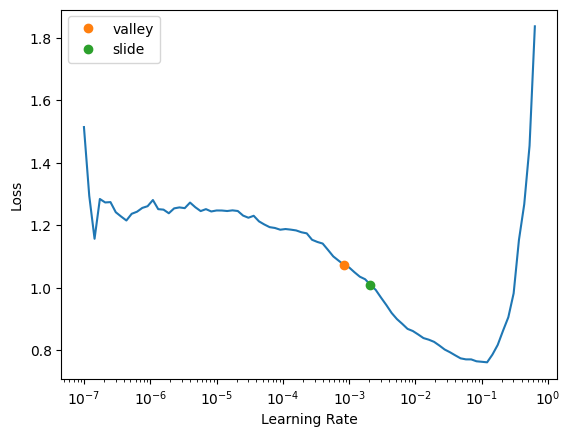

In [7]:
learn.lr_find(suggest_funcs=(valley, slide))

In [30]:
learn.fine_tune(6, 0.01)

epoch,train_loss,valid_loss,error_rate,time
0,0.930016,0.780538,0.179894,00:03


epoch,train_loss,valid_loss,error_rate,time
0,0.333015,0.327057,0.095238,00:04
1,0.331591,0.407703,0.126984,00:03
2,0.325280,0.270014,0.084656,00:04
3,0.268671,0.200305,0.052910,00:04
4,0.229344,0.178914,0.068783,00:03
5,0.191675,0.185680,0.074074,00:04


#### Sort our test images before loading

In [31]:
def extract_number(path):
    match = re.search(r'(\d+)\.jpg$', path.name)
    return int(match.group(1))

In [32]:
tst_files = get_image_files(path/'test/test').sorted(key=extract_number)
test_dl = learn.dls.test_dl(tst_files)
preds, _ = learn.tta(dl=test_dl)

### Format for submission via .csv

In [33]:
sub_df = pd.read_csv(path/'test.csv')
sub_df['Label'] = preds.argmax(dim=1)
sub_df.to_csv('submission.csv', index=False)
!head submission.csv

Image,Label
946.jpg,1
947.jpg,1
948.jpg,1
949.jpg,1
950.jpg,0
951.jpg,1
952.jpg,1
953.jpg,1
954.jpg,0


### This submission matches the 1st place standing on the private leaderboard!

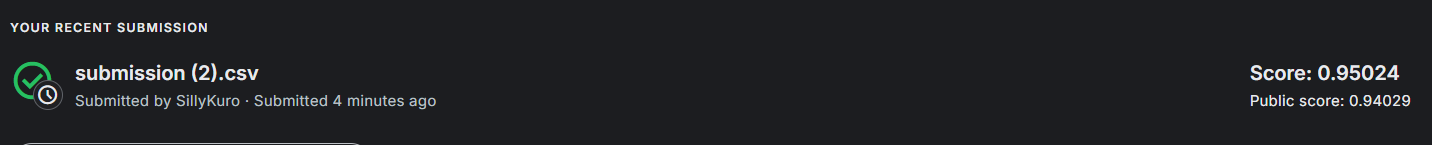